# PyGEM MCMC calibration analysis - regional

Brandon Tober, David Rounce<br>
Carnegie Mellon University<br>
Created: 25OCT2025<br><br>

The main objective of this notebook is to assess the performance of MCMC calibration method for a given region. The analysis in this notebook assumes that three MCMC chains have been run for each glacier in a region of interest, which we'll now assess.

>**Note:** in this notebook, any PyGEM Python scripts that are called will be preceeded by ```!```. In Jupyter Notebook, the ```!``` character is used to execute shell commands directly from a notebook cell. When you prefix a command with ```!```, Jupyter sends it to the system's command-line shell for execution, instead of interpreting it as Python code. Command-line arguments are also bracketed (e.g., ```{arg}```), when passing Python variables to a command-line shell from within a Jupyter Notebook. If executing a given PyGEM script directly from one's terminal, remove the ```!``` character and brackets ```{}``` around arguments.
>
>**Also note:** some useful information for any PyGEM script can be displayed by running
```!script -h```


If the calibration has not yet been completed, first run 3 MCMC calibration chains.
>**Note:** check option_use_emulator under the MCMC_params in ~/PyGEM/config.yaml. If `['calib']['MCMC_params']['option_use_emulator']` is `true`, the calibration procedure must first have been completed using the **emulator** calibration option, after which regional priors should be constrained using the *run_mcmc_priors.py* script (regional priors have already been processed by [Rounce et al. (2013)](https://www.science.org/doi/10.1126/science.abo1324) and shared along with PyGEM's [sample dataset](https://drive.google.com/file/d/1NUbAzHSeK5NAEWm90vPMmFpzjrP0EAiZ) - *priors_region.csv*). Steps detailed briefly below (if one does not wish to run MCMC calibration with the **emulator** and instead run the full PyGEM mass balance model, set `option_use_emulator` to `false` and skip to the third command):

```bash
!run_calibration -rgi_region01 {region} -option_calibration emulator
!run_mcmc_priors -rgi_region01 {region} # note: this step is optional, as regional priors were already constrained and shared with PyGEMs sample data - from your the **root** PyGEM data path look for /Output/calibration/regional_priors.csv
!run_calibration -rgi_region01 {region} -option_calibration MCMC -nchains 3
```

See the *run_calibration.ipynb* Jupyter Notebook for further demonstration on MCMC calibration.

We will load the resulting MCMC calibration chains and assess the chain convergence (Gleman-Rubin statistic; [Gelman and Rubin, 1992](https://doi.org/10.1214/ss/1177011136)) and the effective sample size (number of independent samples) for each glacier. We seek a calibration that results chain convergence (Gelman-Rubin ~1) and an effective sample size of ~100+ for each glacier.

In [ ]:
### imports ###
import os, pickle, glob, copy, sys, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import arviz as az
import xarray as xr
import matplotlib.image as mpimg
# pygem imports
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.
import pygem.pygem_modelsetup as modelsetup
from pygem import mcmc
from pygem.shop import oib
# set some plotting defaults
plt.rcParams["font.family"] = "arial"
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

## Regional MCMC calibration
We'll do a more extensive regaional calibration following from the *run_calibration.ipynb* MCMC calibration. Given that the **emulator** calibration option has already been comleted, we'll run **MCMC** calibration with 3 chains, and a more adequate chain length.

> ⚠️ **Warning:** The following cell may take a significant amount of time to run (~45 minutes using 8 cores on a laptop for RGI region 6)

In [2]:
# RGI region of interest - following the run_calibration.ipynb notebook, we'll test 6 (Iceland)
region = 6
num_cores=8                 # number of cores to parallelize across, change depending on how many cores you have/want to utilize
calib_opt = 'MCMC'          # calibration option
chain_length = 10000        # length of each MCMC chain. we have found 10-20k to be sufficient for chain convergence and a desireable effective sample size
num_chains= 3               # number of MCMC chains. we will run 3 to test the convergence between and across chains
### comment/uncomment the following line depending on whether or not MCMC calibration was already completed for specified region with the above parameters ###
# !run_calibration -rgi_region01 {region} -ref_startyear 2000 -ref_endyear 2019 -ref_climate_name ERA5 -option_calibration {calib_opt} -chain_length {chain_length} -nchains {num_chains} -ncores {num_cores}

In [3]:
# define output calibration path
datpath = pygem_prms['root']+f'/Output/calibration/{str(region).zfill(2)}/'

In [4]:
# get rgi table for all glaciers - this is used to get the area of each glacier to plot against
rgi_glacs = modelsetup.selectglaciersrgitable(rgi_regionsO1=[region])

This study is focusing on 568 glaciers in region [6]


In the cell below we'll loop through all output calibration json files, load the parameters for each chain, and run some diagnostic statistics (median, mean, standard deviation, interquartile range, minimum, maximum, effective sample size, and chain convergence)

In [5]:
# assuming we ran three chains, each output json calibration file will have 
# a key for each parameter pertaining to `chain_0`, `chain_1`, and `chain_2`
chain_ns = [0,1,2]

# keys (variables) of interest
ks = ['kp','tbias','ddfsnow','ddfice','mb_mwea']

# Define the list of functions - note, the chain convergence will be assessed separately using arviz.rhat()
stats = [
    lambda x: float(np.min(x)),
    lambda x: float(np.max(x)),
    lambda x: float(np.median(x)),
    lambda x: float(np.mean(x)),
    lambda x: float(np.std(x)),
    lambda x: float(np.percentile(x, 75) - np.percentile(x, 25)), 
    mcmc.effective_n
    ]
# associated keys to use for each stat
stats_ks = ['min','max','median','mean','std','iqr','n_eff']

# create master mcmc_stats dictionary which will hold results of all glaciers
mcmc_stats = {}
# loop through all calibration files
for f in sorted(glob.glob(datpath + '/*-modelprms_dict.json')):
    try:
        # get RGI glacier number
        reg, glacno = f.split('/')[-1].split('.')[:2]
        glacno = reg + '.' + glacno[:5]
        # open json file
        with open(f,'r') as fin:
            # access MCMC key
            prms_dict = json.load(fin)['MCMC']
            # initialize stats dictionary for individual glacier
            glac_stats = {}
            # loop over variables
            for k in ks:
                # create key in glac_stats for variable which will also be a dictionary
                glac_stats[k] = {}
                # go through each chain and calculate some stats on each chain for each variable
                for n in chain_ns:
                    glac_stats[k][f'chain_{n}'] = {}
                    # loop through each statistic
                    for i, s in enumerate(stats_ks):
                        glac_stats[k][f'chain_{n}'][s] = stats[i](prms_dict[k][f'chain_{n}'])

                # calculate the gelman-rubin stat for each variable across all chains
                # stack chains into a single 2d array which will be passed to arviz using the from_dict() method
                chains = np.array([prms_dict[k][f'chain_{n}'] for n in chain_ns])
                # convert the chains into an InferenceData object
                idata = az.from_dict(posterior={k: chains})
                # calculate the Gelman-Rubin statistic (rhat)
                glac_stats[k]['rhat'] = float(az.rhat(idata).to_array().values[0])

            # also assess the acceptance rate for each chain
            glac_stats['ar'] = {}
            for n in chain_ns:
                glac_stats['ar'][f'chain_{n}'] = {}
                # take 100-samle rolling average of the acceptance rate
                rolling_ar = np.convolve(np.array(prms_dict['ar'][f'chain_{n}']), np.ones(100)/100, mode='valid')
                # loop through each statistic
                for i, s in enumerate(stats_ks[:-2]):
                    glac_stats['ar'][f'chain_{n}'][s] = stats[i](rolling_ar)

        # get glacier size
        glac_stats['area'] = float(rgi_glacs.loc[rgi_glacs['glacno'] == glacno, 'Area'].iloc[0])
        # store glac_stats within mcmc_glac_stats
        mcmc_stats[glacno] = glac_stats
    except Exception as err:
        print(glacno, err)

In [6]:
# what's our regional MCMC stats dictionary look like?
mcmc_stats[list(mcmc_stats.keys())[0]]['kp']

{'chain_0': {'min': 0.43538125179206855,
  'max': 4.375853572353839,
  'median': 1.9878563258018573,
  'mean': 2.0766165208350356,
  'std': 0.7759757266654154,
  'iqr': 1.0755680632868925,
  'n_eff': 97},
 'chain_1': {'min': 0.45368355690660334,
  'max': 5.414083623885296,
  'median': 2.1542175782263704,
  'mean': 2.241462448051648,
  'std': 0.8910304728626307,
  'iqr': 1.2552770088674523,
  'n_eff': 72},
 'chain_2': {'min': 0.4210307286344257,
  'max': 5.102132540144757,
  'median': 2.0137587395685728,
  'mean': 2.074288799605663,
  'std': 0.7862135883950141,
  'iqr': 1.0650658902552634,
  'n_eff': 68},
 'rhat': 1.0058756360485765}

In the next cell we'll plot the Gelman-Rubin convergence metric for each glacier across each parameter, the glacierwide specific mass balance ($\dot{B}$), precipitation factor ($k_p$), temperature bias ($T_{bias}$), and the degree-day factor of snow ($f_{snow}$), as well as the effective sample size, and the average acceptance rate.

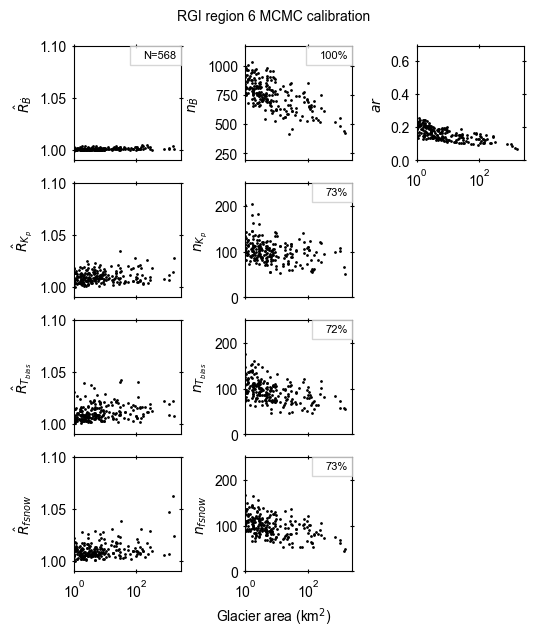

In [7]:
# create a figure that has a column for the Gelman-Rubin as well as the effective sample size for each parameter, 
# and also plot the average acceptance rate across all chains

# initialize the figure (4 rows, 3 columns)
s=1
fig = plt.figure(figsize=(5,6))
gs = gridspec.GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], figure=fig)

# create subplots
axes = []
for i in range(4):
    axes.append(fig.add_subplot(gs[i, 0]))  # left column, 4 rows
for i in range(4):    
    axes.append(fig.add_subplot(gs[i, 1]))  # middle column, 4 rows
axes.append(fig.add_subplot(gs[0, 2]))      # top right panel

# get each glacier's area - we'll use this as the xaxis
xs = [mcmc_stats[g]['area'] for g in mcmc_stats.keys()]

for i, k in enumerate(['mb_mwea','kp','tbias','ddfsnow']):
    # plot gelman-rubin for each glacier
    rhats = [mcmc_stats[g][k]['rhat'] for g in mcmc_stats.keys()]
    axes[i].scatter(xs, rhats, c='k',s=s)

    # plot average n_eff across all chains
    n_effs = [np.nanmean([mcmc_stats[g][k][f'chain_{n}']['n_eff'] for n in [0,1,2]]) for g in mcmc_stats.keys()]
    axes[i+4].scatter(xs, n_effs, c='k',s=s)

    # get count where n_eff >=100
    pct = int(round(100*(np.count_nonzero(np.asarray(n_effs)>=100)/len(n_effs))))
    # annotate percentage
    axes[i+4].plot([],[],label=f'{pct}%')
    axes[i+4].legend(handlelength=0,fancybox=False, borderaxespad=0)
    
# plot average acceptance rate across all chains
ars = [np.nanmean([mcmc_stats[g]['ar'][f'chain_{n}']['mean'] for n in [0,1,2]]) for g in mcmc_stats.keys()]
axes[-1].scatter(xs, ars, c='k',s=s)

# annotate total number of glaciers
axes[0].plot([],[],label=f'N={len(mcmc_stats.keys())}')
axes[0].legend(handlelength=0,fancybox=False, borderaxespad=0)

# loop through all axes, add ticks on all sides
for i,a in enumerate(axes):
    a.xaxis.set_ticks_position('both')
    a.yaxis.set_ticks_position('both')
    a.tick_params(axis="both",direction="inout")
    # make xaxis log-scale
    a.set_xscale('log')
    # set xmin as 1:max
    a.set_xlim([1,a.get_xlim()[1]])
    # remove xticklabels from middle panels not at the bottom of each column
    if i not in [3,7,8]:
        a.set_xticklabels([])
    
# manually set some ylimits
for i,a in enumerate(axes):
    if i<4:
        a.set_ylim([0.99, 1.1])
    if (i>4) & (i<8):
        a.set_ylim([0, 250])

axes[-1].set_ylim([0,axes[-1].get_ylim()[-1]])

# set ylabels for each panel
axes[0].set_ylabel(r'$\hat{{R}}_{\dot{{B}}}$')
axes[1].set_ylabel(r'$\hat{{R}}_{K_{p}}$')
axes[2].set_ylabel(r'$\hat{{R}}_{T_{bias}}$')
axes[3].set_ylabel(r'$\hat{{R}}_{fsnow}$')
axes[4].set_ylabel(r'${n}_{\dot{{B}}}$')
axes[5].set_ylabel(r'${n}_{K_{p}}$')
axes[6].set_ylabel(r'${n}_{T_{bias}}$')
axes[7].set_ylabel(r'${n}_{fsnow}$')
axes[-1].set_ylabel(r'${{ar}}$')
# xaxis label
fig.text(0.5, 0, r'Glacier area (km$^2$)', va='center',ha='center')
# figure title
fig.text(0.5, 1, f'RGI region {region} MCMC calibration', va='center',ha='center')
plt.subplots_adjust(left=0.1, bottom=0.075, right=1, top=0.95, wspace=0.6)

Overall this looks pretty good - most glaciers have an effective sample size > 100 for each parameter, and chains seem to converge to ~1. These metrics may even improve with a greater chain length.